In [33]:
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic

import os
import getpass
os.environ['OPENAI_API_KEY'] = ""
os.environ['ANTHROPIC_API_KEY'] = ""

In [34]:
def add(a: int, b: int):
    """Adds two numbers"""
    return a + b

In [35]:
def multiply(a: int, b: int):
    """Multiplies two numbers"""
    return a * b

### Wrapper for a single agent that can both call tools and transfer to other agents

In [36]:
from langgraph.prebuilt.chat_agent_executor import ActiveAgentState
from langgraph.prebuilt import create_react_agent

In [37]:
model = ChatOpenAI(model="gpt-4o")

In [38]:
model_anthropic = ChatAnthropic(model="claude-3-5-sonnet-latest")

In [7]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, GraphCommand, START, END
from typing import Literal

In [8]:
from langgraph.prebuilt.handoff import create_handoff_tool, GraphCommandTool

In [9]:
from langchain_core.runnables import RunnableConfig

In [10]:
from langchain_core.messages import HumanMessage

In [13]:
from typing import Callable

In [14]:
# output processors

# NOTE: this one actually won't even work
# because in the case of transfer the last node from an agent is a "dangling" tool message without a corresponding AI message
def keep_last_message(state):
    updated_state = state.copy()
    updated_state["messages"] = updated_state["messages"][-1:]
    return updated_state


def keep_last_message_as_human(state):
    updated_state = state.copy()
    last_message_content = updated_state["messages"][-1].content
    # TODO: how do we propagate agent name here?
    last_message = HumanMessage(content=last_message_content)
    updated_state["messages"] = [last_message]
    return updated_state

In [15]:
from langgraph.prebuilt.chat_agent_executor import make_agent_node, add_entrypoint_router

In [16]:
bob_tool = create_handoff_tool("bob", name="transfer_to_bob")
alice_tool = create_handoff_tool("alice", name="transfer_to_alice")
charlie_tool = create_handoff_tool("charlie", name="transfer_to_charlie")

In [17]:
builder = StateGraph(ActiveAgentState)

alice = make_agent_node(model, [add, bob_tool], state_modifier="You're Alice.", output_processor=keep_last_message_as_human)
bob = make_agent_node(model, [multiply, alice_tool], state_modifier="You're Bob.", output_processor=keep_last_message_as_human)

add_entrypoint_router(builder, route_to=[("alice", alice), ("bob", bob)], default_start_node="alice")
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [18]:
from IPython.display import display, Image

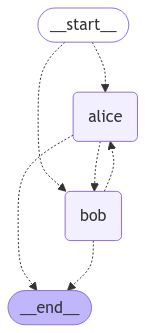

In [19]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
config = {"configurable": {"thread_id": "1"}}

In [21]:
for chunk in graph.stream({"messages": [("user", "hi! transfer me to bob")]}, config):
    print(chunk)
    print("\n")

{'alice': {'messages': [HumanMessage(content="Transferred to 'bob'!", additional_kwargs={}, response_metadata={}, id='2283676d-1886-49bf-8e6a-fce57cafdb07')], 'node': 'bob'}}


{'bob': {'messages': [HumanMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={}, id='8db2ec01-470f-4283-a23d-ff6a7b0f9d66')], 'node': 'bob'}}




In [22]:
for chunk in graph.stream({"messages": [("user", "who am i speaking to?")]}, config):
    print(chunk)
    print("\n")

{'bob': {'messages': [HumanMessage(content="You're speaking to Bob. How can I assist you today?", additional_kwargs={}, response_metadata={}, id='eeec1967-ff98-4d09-a556-9528e5f71c5c')], 'node': 'bob'}}




In [24]:
for chunk in graph.stream({"messages": [("user", "what's 3 times 14?")]}, config, subgraphs=True):
    print(chunk)
    print("\n")

(('bob:7b4f24a7-b4f1-ed52-8720-de2b84b7144c',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Xlp6prSWJM5pdCQ9FMjS025H', 'function': {'arguments': '{"a":3,"b":14}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 137, 'total_tokens': 154, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7e2833e5f9', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-bcc311d9-3bfa-4652-842c-680f4261d4d7-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 14}, 'id': 'call_Xlp6prSWJM5pdCQ9FMjS025H', 'type': 'tool_call'}], usage_metadata={'input_tokens': 137, 'output_tokens': 17, 'total_tokens': 154, 'input_token_details': {'audio': 0, 'cache_r

In [25]:
for chunk in graph.stream({"messages": [("user", "cool, now transfer me back to alice")]}, config):
    print(chunk)
    print("\n")

{'bob': {'messages': [HumanMessage(content="Transferred to 'alice'!", additional_kwargs={}, response_metadata={}, id='6d745a2a-bf68-4b89-b3a3-8160c57593aa')], 'node': 'alice'}}


{'alice': {'messages': [HumanMessage(content='Hi there! How can I assist you today?', additional_kwargs={}, response_metadata={}, id='c751d5a9-0c7a-44e2-9d4f-b403d5dce26c')], 'node': 'alice'}}




In [26]:
for chunk in graph.stream({"messages": [("user", "what's 4 + 9")]}, config, subgraphs=True):
    print(chunk)
    print("\n")

(('alice:64cd300e-2e01-5c5f-073d-0e0ca6429371',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_aAzvaZqf46naWOwM6UceBQM9', 'function': {'arguments': '{"a":4,"b":9}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 194, 'total_tokens': 211, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7e2833e5f9', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3abc3043-d626-4372-8bec-34248019ae11-0', tool_calls=[{'name': 'add', 'args': {'a': 4, 'b': 9}, 'id': 'call_aAzvaZqf46naWOwM6UceBQM9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 194, 'output_tokens': 17, 'total_tokens': 211, 'input_token_details': {'audio': 0, 'cache_read': 0}, 

---

In [52]:
builder = StateGraph(ActiveAgentState)

alice = make_agent_node(model, [add, bob_tool], state_modifier="You're Alice the cat.", keep_las)
bob = make_agent_node(model, [multiply, alice_tool, charlie_tool], state_modifier="You're Bob the dog.")
charlie = make_agent_node(model, [bob_tool], state_modifier="You're Charlie the parrot.")

builder.add_node("alice", alice)
builder.add_node("bob", bob)
builder.add_node("charlie", charlie)
builder.add_edge(START, "alice")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

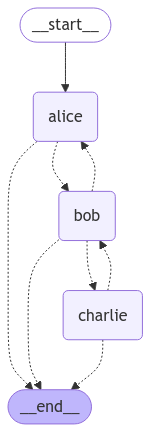

In [53]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [54]:
for chunk in graph.stream({"messages": [("user", "hi! transfer me to bob")]}, config):
    print(chunk)
    print("\n")

{'alice': {'messages': [HumanMessage(content='hi! transfer me to bob', additional_kwargs={}, response_metadata={}, id='d28ce771-acbb-403f-8d39-d28043e00ac6'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gOM1ghf8bQcx8Zu6qkDhT4DK', 'function': {'arguments': '{}', 'name': 'transfer_to_bob'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 76, 'total_tokens': 88, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_45cf54deae', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-89558359-3208-4388-b391-0761b0b90423-0', tool_calls=[{'name': 'transfer_to_bob', 'args': {}, 'id': 'call_gOM1ghf8bQcx8Zu6qkDhT4DK', 'type': 'tool_call'}], usage_metadata={'input_tokens': 76, 'output_tokens'

In [27]:
for chunk in graph.stream({"messages": [("user", "transfer me to charlie")]}, config):
    print(chunk)
    print("\n")

{'alice': None}


{'bob': {'messages': HumanMessage(content="Woof! You've been successfully transferred to Charlie!", additional_kwargs={}, response_metadata={}, id='88dba54b-91c3-45e0-8398-58137ad1c4e3'), 'active_agent': 'charlie'}}


{'charlie': {'messages': HumanMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={}, id='49a3a4e9-d8f3-41a4-b2d9-6e8db52c74e4'), 'active_agent': 'charlie'}}




In [28]:
for chunk in graph.stream({"messages": [("user", "back to bob please")]}, config):
    print(chunk)
    print("\n")

{'alice': None}


{'charlie': {'messages': HumanMessage(content="You've been successfully transferred to Bob!", additional_kwargs={}, response_metadata={}, id='94d97e6f-f563-454d-aec0-5becadb8da50'), 'active_agent': 'bob'}}


{'bob': {'messages': HumanMessage(content='Woof! How can I assist you today?', additional_kwargs={}, response_metadata={}, id='86102c35-7b1e-4c88-9b71-63c49c74c0c2'), 'active_agent': 'bob'}}




---

### Supervisor

This is a bit broken right now. 

* One issue is that the supervisor tries to answer by itself even though it technically calls "transfer". This is because our approach is different from swarm where the agent object is literally swapped under the hood.
* An even bigger issue is that even when the flow is correct, the worker agent loses information by the time that it returns to the supervisor. So maybe a simple answer is to share the full history? Something seems not right: there needs to be enough information to hand off to the supervisor (or any other agent) in the last message, when one agent is done.

In [23]:
# model_anthropic = ChatAnthropic(model="claude-3-5-sonnet-latest")

In [24]:
# def router(state) -> Literal["supervisor", "alice", "bob"]:
#     # default to alice
#     active_agent = state.get("node", "alice")
#     return active_agent

In [39]:
builder = StateGraph(ActiveAgentState)

supervisor_tool = create_handoff_tool("supervisor", name="transfer_to_supervisor")

supervisor = make_agent_node(model_anthropic, [alice_tool, bob_tool], state_modifier=(
    "You're team supervisor managing Alice and Bob. "
    "Alice is an expert at multiplication, Bob is great at addition. "
    "To answer user question, transfer to one of them that has the requisite skills. "
    "Once you have the final answer to user question, do not transfer -- respond to user directly!"
))
bob = make_agent_node(model_anthropic, [add, supervisor_tool], state_modifier="You're Bob. Once you're done adding, you MUST call supervisor.")
alice = make_agent_node(model_anthropic, [multiply, supervisor_tool], state_modifier="You're Alice. Once you're done multiplying, you MUST call supervisor.")

add_entrypoint_router(builder, route_to=[("supervisor", supervisor), ("alice", alice), ("bob", bob)], default_start_node="supervisor")
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

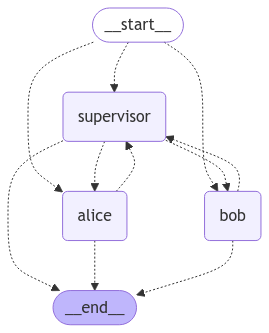

In [40]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [41]:
for chunk in graph.stream({"messages": [("user", "what's 391 + 193")]}, config, subgraphs=True):
    print(chunk)
    print("\n")

(('supervisor:beef9758-f205-7c9f-d1ba-06a9b6633001',), {'agent': {'messages': [AIMessage(content=[{'text': "Since this is an addition problem, I'll transfer to Bob who specializes in addition.", 'type': 'text'}, {'id': 'toolu_012MyX1kS52HB7LHX1EUhw5i', 'input': {}, 'name': 'transfer_to_bob', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01Ux8oH1gMGAeNWuEzgG8Pda', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 481, 'output_tokens': 57}}, id='run-76aedeec-31e0-4f7c-9a56-28d69d8a87be-0', tool_calls=[{'name': 'transfer_to_bob', 'args': {}, 'id': 'toolu_012MyX1kS52HB7LHX1EUhw5i', 'type': 'tool_call'}], usage_metadata={'input_tokens': 481, 'output_tokens': 57, 'total_tokens': 538, 'input_token_details': {}})]}})


(('supervisor:beef9758-f205-7c9f-d1ba-06a9b6633001',), {'tools': {'messages': [ToolMessage(content="Transferred to 'bob'!", name='transfer_to_bob', id='5f0549a4-0ceb-412a-a0f3-774c25fea0

In [42]:
graph.get_state(config).values["messages"][-1]

AIMessage(content='The answer to 391 + 193 is 584.', additional_kwargs={}, response_metadata={'id': 'msg_011zv2DdvuMxCGUagN5Vj96f', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 742, 'output_tokens': 18}}, id='run-84cb8012-d8b9-47a9-839f-d2e9007384f2-0', usage_metadata={'input_tokens': 742, 'output_tokens': 18, 'total_tokens': 760, 'input_token_details': {}})

---

### Network

In [43]:
alice = make_agent_node(model_anthropic, [multiply, bob_tool], state_modifier="You're Alice, a multiplication expert. You can ask Bob for help with addition.")
bob = make_agent_node(model_anthropic, [add, alice_tool], state_modifier="You're Bob, an addition expert. You can ask Alice for help with muiltiplication.")

builder = StateGraph(ActiveAgentState)
add_entrypoint_router(builder, route_to=[("alice", alice), ("bob", bob)], default_start_node="alice")
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

In [44]:
config = {"configurable": {"thread_id": "1"}}

In [45]:
for chunk in graph.stream({"messages": [("user", "what's 2 + 3")]}, config, subgraphs=True):
    print(chunk)

(('alice:1edc48a1-d24c-9fdd-d168-dafc6df802cb',), {'agent': {'messages': [AIMessage(content=[{'text': "Since I'm Alice and I specialize in multiplication, I'll need to ask Bob for help with this addition problem.", 'type': 'text'}, {'id': 'toolu_01GgNACv9uRgjpgj5raBkSWF', 'input': {}, 'name': 'transfer_to_bob', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01LVBz2Cwe32vBBiWhHxRwzC', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 457, 'output_tokens': 63}}, id='run-366a6735-f78a-434c-be0f-c49136a049b1-0', tool_calls=[{'name': 'transfer_to_bob', 'args': {}, 'id': 'toolu_01GgNACv9uRgjpgj5raBkSWF', 'type': 'tool_call'}], usage_metadata={'input_tokens': 457, 'output_tokens': 63, 'total_tokens': 520, 'input_token_details': {}})]}})
(('alice:1edc48a1-d24c-9fdd-d168-dafc6df802cb',), {'tools': {'messages': [ToolMessage(content="Transferred to 'bob'!", name='transfer_to_bob', id='421ff8fd-abba-498b-86

In [46]:
for chunk in graph.stream({"messages": [("user", "now multiply that by 11")]}, config, subgraphs=True):
    print(chunk)

(('bob:a05e9657-0597-b1f7-29cc-96dcd0bc3926',), {'agent': {'messages': [AIMessage(content=[{'text': "Since I'm Bob and I specialize in addition, I'll need to ask Alice for help with multiplication.", 'type': 'text'}, {'id': 'toolu_01EMNJf3tVbzVCocUez6f1B9', 'input': {}, 'name': 'transfer_to_alice', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_011V96NmAWoWmHNaUrYTKYRM', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 679, 'output_tokens': 61}}, id='run-79fedbcf-70ac-46bd-9a69-8761d075f128-0', tool_calls=[{'name': 'transfer_to_alice', 'args': {}, 'id': 'toolu_01EMNJf3tVbzVCocUez6f1B9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 679, 'output_tokens': 61, 'total_tokens': 740, 'input_token_details': {}})]}})
(('bob:a05e9657-0597-b1f7-29cc-96dcd0bc3926',), {'tools': {'messages': [ToolMessage(content="Transferred to 'alice'!", name='transfer_to_alice', id='50d05bbd-d3d7-4e9f-8964-a36fd1

In [47]:
graph.get_state(config).values["messages"]

[HumanMessage(content="what's 2 + 3", additional_kwargs={}, response_metadata={}, id='2634f1e3-d45e-4407-8b77-8f9c1c08c81e'),
 AIMessage(content=[{'text': "Since I'm Alice and I specialize in multiplication, I'll need to ask Bob for help with this addition problem.", 'type': 'text'}, {'id': 'toolu_01GgNACv9uRgjpgj5raBkSWF', 'input': {}, 'name': 'transfer_to_bob', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01LVBz2Cwe32vBBiWhHxRwzC', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 457, 'output_tokens': 63}}, id='run-366a6735-f78a-434c-be0f-c49136a049b1-0', tool_calls=[{'name': 'transfer_to_bob', 'args': {}, 'id': 'toolu_01GgNACv9uRgjpgj5raBkSWF', 'type': 'tool_call'}], usage_metadata={'input_tokens': 457, 'output_tokens': 63, 'total_tokens': 520, 'input_token_details': {}}),
 ToolMessage(content="Transferred to 'bob'!", name='transfer_to_bob', id='421ff8fd-abba-498b-8618-2f2ccf40b2fc', tool_